# Atmospheric Rivers: Filtering by Criteria

This notebook will import functions from the `ar_detection.py` module to expose the processing flow and to show a few examples.
Production runs could also be orchestrated from this notebook to leverage the use of an interactive Dask client if/when needed. Before executing this notebook be sure you've set your `AR_DATA_DIR` environment variable, and have executed both the `download.py` and `compute_ivt.py` scripts.

In [1]:
import random

import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from tqdm import tqdm

from config import ar_params, ard_fp, shp_fp, csv_fp, ak_shp, landfall_shp, landfall_csv, landfall_events_shp, landfall_events_csv, coastal_impact_shp, coastal_impact_csv

# functions to create the binary "blobs" of IVT exceedance
from ar_detection import compute_intensity_mask, label_contiguous_mask_regions
# functions to measure the requisite blob properties
from ar_detection import generate_region_properties, get_data_for_ar_criteria, get_azimuth_of_furthest_points, get_directional_coherence, get_length_width_ratio, get_major_axis_haversine_distance, get_poleward_strength
# functions test whether or not criteria are met
from ar_detection import apply_criteria, filter_ars
# functions to generate vectorized output
from ar_detection import create_geodataframe_with_all_ars, create_shapefile, landfall_ars_export

In [2]:
# inspect criteria, note that `window` and `ivt_percentile` are used in the IVT computation, not in the AR filtering done here
ar_params

{'window': 75,
 'ivt_percentile': 90,
 'ivt_floor': 100,
 'direction_deviation_threshold': 45,
 'mean_meridional': 50,
 'orientation_deviation_threshold': 45,
 'min_axis_length': 2000}

In [3]:
ivt_ds = xr.open_dataset(ard_fp)
ivt_ds.rio.write_crs("epsg:4326", inplace=True)
ivt_ds

<xarray.Dataset>
Dimensions:       (time: 61364, latitude: 225, longitude: 237)
Coordinates:
  * time          (time) datetime64[ns] 1980-01-01 ... 2021-12-31T18:00:00
  * longitude     (longitude) float32 -179.0 -178.8 -178.5 ... -120.2 -120.0
  * latitude      (latitude) float32 66.0 65.75 65.5 65.25 ... 10.5 10.25 10.0
    spatial_ref   int64 0
Data variables:
    p72.162       (time, latitude, longitude) float32 ...
    ivt_mag       (time, latitude, longitude) float32 ...
    ivt_dir       (time, latitude, longitude) float32 ...
    ivt_quantile  (time, latitude, longitude) float64 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-09-12 23:42:01 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [4]:
%%time
ivt_ds["thresholded"] = compute_intensity_mask(ivt_ds["ivt_mag"], ivt_ds["ivt_quantile"], ar_params["ivt_floor"])

CPU times: user 25 s, sys: 31.8 s, total: 56.8 s
Wall time: 58.2 s


In [5]:
%%time
labeled_regions = label_contiguous_mask_regions(ivt_ds["thresholded"])

CPU times: user 1min 28s, sys: 4.39 s, total: 1min 33s
Wall time: 1min 33s


In [6]:
%%time
ar_di = generate_region_properties(labeled_regions, ivt_ds)

CPU times: user 10min 7s, sys: 1min 24s, total: 11min 32s
Wall time: 11min 32s


In [7]:
%%time
ar_di = get_data_for_ar_criteria(ar_di, ivt_ds)

Getting axis length (km) for each AR target:: 100%|██████████| 61364/61364 [09:52<00:00, 103.56it/s]
Getting overall orientation (azimuth) for each AR target:: 100%|██████████| 61364/61364 [10:38<00:00, 96.14it/s] 
Getting mean poleward strength for each AR target:: 100%|██████████| 61364/61364 [01:00<00:00, 1012.61it/s]
Getting directional coherence for each AR target:: 100%|██████████| 61364/61364 [02:44<00:00, 373.18it/s]
Getting total IVT strength for each AR target:: 100%|██████████| 61364/61364 [00:22<00:00, 2708.97it/s]
Getting relative IVT strength for each AR target:: 100%|██████████| 61364/61364 [00:24<00:00, 2515.46it/s]

CPU times: user 28min 49s, sys: 1min 11s, total: 30min
Wall time: 29min 52s


In [8]:
%%time
ar_di = apply_criteria(ar_di)

100%|██████████| 61364/61364 [00:02<00:00, 20602.94it/s]

CPU times: user 2.86 s, sys: 147 ms, total: 3.01 s
Wall time: 2.98 s


In [9]:
# criteria exploration
# how many labeled regions meet the different numbers of criteria? 
# note that some criteria (overall orientation consistency) may oscillate between pass and fail depending on size of spatial domain


blob_count = 0

for b in ar_di:
    no_blobs = len(ar_di[b]["ar_targets"])
    blob_count = blob_count + no_blobs

print("TOTAL CANDIDATE ARs: " + str(blob_count))

crit_no = [1,2,3,4,5]
blob_crit = []

for c in crit_no:
    ars = filter_ars(ar_di, n_criteria_required=c)

    crit_count = 0

    for a in ars:
        ar_count = len(ars[a])
        crit_count = crit_count + ar_count
    
    blob_crit.append(crit_count)

for c, b in zip(crit_no, blob_crit):
    print("If requiring " + str(c) + " AR criteria, we find " + str(b) + " ARs...")

TOTAL CANDIDATE ARs: 627025


100%|██████████| 61364/61364 [00:00<00:00, 169216.47it/s]

If requiring 1 AR criteria, we find 627025 ARs...
If requiring 2 AR criteria, we find 601141 ARs...
If requiring 3 AR criteria, we find 412981 ARs...
If requiring 4 AR criteria, we find 143179 ARs...
If requiring 5 AR criteria, we find 23384 ARs...


In [10]:
%%time
# default criteria is the maximum (5)
output_ars = filter_ars(ar_di, n_criteria_required=5)

100%|██████████| 61364/61364 [00:00<00:00, 169725.87it/s]

CPU times: user 365 ms, sys: 5 ms, total: 370 ms
Wall time: 366 ms


Text(0.5, 1.0, 'Labeled AR candidate regions')

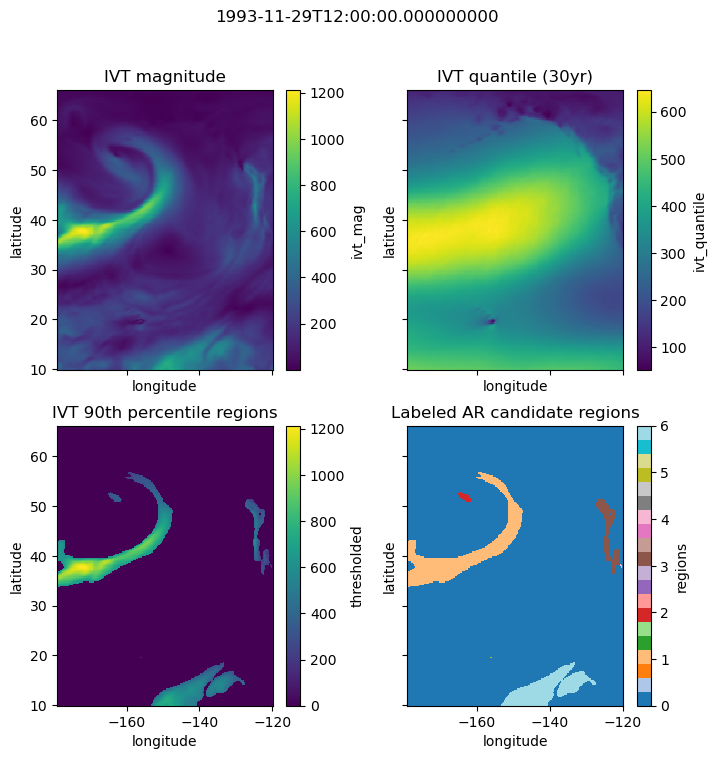

In [11]:
#plot a random timestep from the filtered ARs

random_date = random.choice(list(output_ars.keys()))
fig, axes = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(8,8))
plt.subplots_adjust(wspace=0.3)
plt.suptitle(random_date)

ivt_ds["ivt_mag"].sel(time=random_date).plot(ax=axes[0,0])
ivt_ds["ivt_quantile"].sel(time=random_date).plot(ax=axes[0,1])
ivt_ds["thresholded"].sel(time=random_date).plot(ax=axes[1,0])
labeled_regions.sel(time=random_date).plot(ax=axes[1,1], cmap="tab20")

axes[0,0].set_title("IVT magnitude")
axes[0,1].set_title("IVT quantile (30yr)")

axes[1,0].set_title("IVT " + str(ar_params['ivt_percentile']) + "th percentile regions")
axes[1,1].set_title("Labeled AR candidate regions")

In [12]:
%%time
#create a master geodataframe of filtered ARs
gdf = create_geodataframe_with_all_ars(output_ars, ar_di, labeled_regions, ivt_ds)

  4%|▍         | 832/21812 [00:19<07:33, 46.31it/s]

100%|██████████| 21812/21812 [08:56<00:00, 40.67it/s] 


CPU times: user 8min 11s, sys: 28.1 s, total: 8min 39s
Wall time: 9min 10s


In [13]:
ivt_ds.close()

,time,blob_label,geometry,length/width ratio,major axis length (km),overall orientation,mean poleward strength,directional_coherence,mean_of_ivt_dir,total ivt strength,relative ivt strength,Coherence in IVT Direction,Mean Meridional IVT,Consistency Between Mean IVT Direction and Overall Orientation,Length,Length/Width Ratio,Criteria Passed
22736,2020-12-01T00:00:00.000000000,1.0,"POLYGON ((-149.62500 61.12500, -149.62500 60.8...",3.0,4113,19,240,81,359,3151694,743,True,True,True,True,True,5


<Axes: >

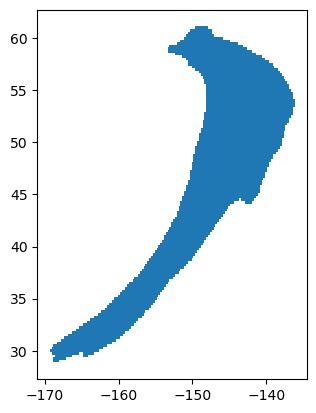

In [14]:
#checking out the Haines 2020 AR event....the region property values seems reasonable when compared to the image! 
display(gdf.loc[gdf['time']=='2020-12-01T00:00:00.000000000'])
gdf.loc[gdf['time']=='2020-12-01T00:00:00.000000000', 'geometry'].plot()

In [15]:
#if not already run from terminal via ar_detection.py....
#export the gdf to shapefile, then filter/export the raw AR shapefile to landfalling ARs, event ARs, and coastal impact point shapefiles.

#create_shapefile(gdf, shp_fp, csv_fp)
#landfall_ars_export(
    # shp_fp,
    # csv_fp,
    # ak_shp,
    # landfall_shp,
    # landfall_csv,
    # landfall_events_shp,
    # landfall_events_csv,
    # coastal_impact_shp,
    # coastal_impact_csv)

In [16]:
#read outputs and AK shp as geodataframes
e_polys = gpd.read_file(landfall_events_shp)
e_pts = gpd.read_file(coastal_impact_shp)
ak = gpd.read_file(ak_shp).to_crs(e_polys.crs)

#join coastal impact points to using event id
e = gpd.GeoDataFrame(e_polys.merge(e_pts, how='left', on='event_id'), geometry='geometry_x', crs=e_polys.crs)

      event_id                start                  end  sumtot_str  \
2223      2223  2020-11-29 00:00:00  2020-12-01 12:00:00    14751224   

      sumrel_str  ratio_m  len_km_m  orient_m  poleward_m  dircoher_m  \
2223        4129      3.0    3015.0      17.0       238.0        78.0   

      mean_dir_m  dur_hrs  tintensity  rintensity  \
2223         3.0     66.0    223503.0        63.0   

                                             geometry_x  \
2223  POLYGON ((-129.87500 65.62500, -129.87500 65.3...   

                       geometry_y  
2223  POINT (-143.95137 60.03367)  


(-180.0, -120.0)

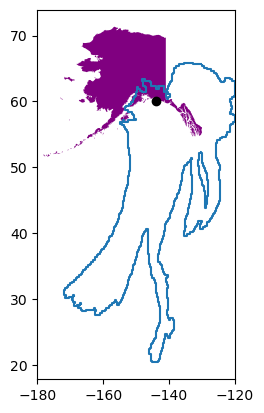

In [17]:
#view properties and plot aggregated Haines 2020 AR Event and coastal impact point with AK shp for context
print(e.loc[[2223]])

ax = ak.plot(color='purple', zorder=1)
e.loc[[2223], 'geometry_x'].boundary.plot(ax=ax, zorder=2)
e.loc[[2223], 'geometry_y'].plot(ax=ax, color='black', zorder=3)
ax.set_xlim([-180, -120])